# Demo exp for bias in encoder

In [ ]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    BertConfig,
    BertForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from tokenizers import BertWordPieceTokenizer
from torch.optim import AdamW

In [2]:
d_model = 624
data_size = 1400
data_length = 128
max_steps = 4500

data_path = "data/conll2003_train.txt"
tokenizer_path = "models/"

In [3]:
dataset = load_dataset("conll2003")
metric = evaluate.load("seqeval")

## Here is some examples for CoNLL-2003 dataset

In [4]:
ner_feature = dataset["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [5]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [6]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [7]:
words = ' '.join(dataset["train"][12]["tokens"])
words

"Only France and Britain backed Fischler 's proposal ."

In [8]:
labels = dataset["train"][0]["ner_tags"]
labels

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [9]:
inputs = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [10]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

## Operations for cls, sep, and other tokens

In [11]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [12]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels

    return tokenized_inputs

In [13]:
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [14]:
def group_by_length(examples, max_len=128):

    curr_idx = 0
    # examples is a dictionary with keys being the column names
    column_names = list(examples.data.keys())

    while curr_idx < len(examples[column_names[0]]):
        next_idx = curr_idx + 1
        curr_len = len(examples[column_names[0]][curr_idx])

        while curr_len < max_len and next_idx < len(examples[column_names[0]]):
            remaining_len = max_len - curr_len
            next_example_len = len(examples[column_names[0]][next_idx]) - 1
            # If the next example is too long, truncate it
            if next_example_len <= remaining_len:
                for column_name in column_names:
                    examples[column_name][curr_idx] += examples[column_name][next_idx][1:]
                    # Remove next example and we won't increment next_idx
                    examples[column_name].pop(next_idx)

                curr_len += next_example_len

            else:
                for column_name in column_names:
                    examples[column_name][curr_idx] += examples[column_name][next_idx][1:remaining_len]
                    # Truncate the next example by remaining_len
                    examples[column_name][next_idx] = examples[column_name][next_idx][remaining_len:]

                curr_len += remaining_len

        curr_idx = next_idx

    return examples

## Split dataset

In [15]:
selected_dataset = dataset["train"].select(range(data_size))

In [16]:
train_set = selected_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=selected_dataset.column_names,
)
valid_set = train_set.map(
    lambda examples: group_by_length(examples, data_length),
    batched=True,
    batch_size=None,
    num_proc=4,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Map (num_proc=4): 100%|██████████| 1400/1400 [00:00<00:00, 14609.72 examples/s]


In [17]:
train_set

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1400
})

In [18]:
valid_set

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 225
})

Average data length:  21.187857142857144
Max data length:  83


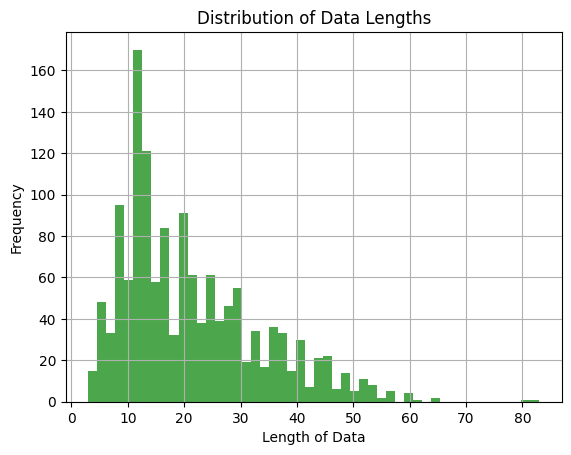

In [19]:
data_lengths = [len(example['input_ids']) for example in train_set]

print("Average data length: ", np.mean(data_lengths))
print("Max data length: ", np.max(data_lengths))

plt.hist(data_lengths, bins=50, alpha=0.7, color='green')
plt.xlabel('Length of Data')
plt.ylabel('Frequency')
plt.title('Distribution of Data Lengths')
plt.grid(True)
plt.show()

Average data length:  125.68
Max data length:  128


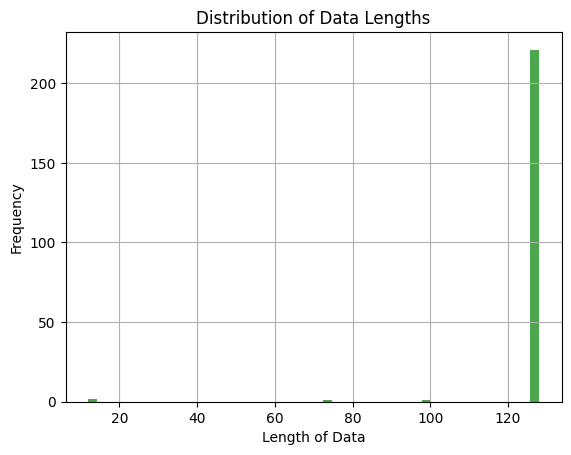

In [20]:
data_lengths = [len(example['input_ids']) for example in valid_set]

print("Average data length: ", np.mean(data_lengths))
print("Max data length: ", np.max(data_lengths))

plt.hist(data_lengths, bins=50, alpha=0.7, color='green')
plt.xlabel('Length of Data')
plt.ylabel('Frequency')
plt.title('Distribution of Data Lengths')
plt.grid(True)
plt.show()

In [21]:
batch = data_collator([train_set[i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [22]:
batch["input_ids"]

tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [23]:
for i in range(2):
    print(train_set[i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


## Training process

In [24]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [25]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=d_model,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=6,
    intermediate_size=d_model * 4,
    classifier_dropout=0.1,
    id2label=id2label,
    label2id=label2id,
    num_labels = 9,
)

model = BertForTokenClassification(config=config)
optimizer = AdamW(model.parameters(), lr=2e-5)
training_args = TrainingArguments(
    evaluation_strategy="steps",
    eval_steps=50,
    max_steps=max_steps,
    metric_for_best_model="f1",
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    output_dir="./models/"+f"{d_model}_{data_size}",
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=1,
    warmup_ratio=0.03,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_set,
    eval_dataset=valid_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
)

## Please check the results on [W & B](https://wandb.ai/lindinan/conll2003_1400/workspace)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()